<a href="https://colab.research.google.com/github/Syilun/TibameAI04/blob/master/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/mnist_%d.png" % epoch)
        plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

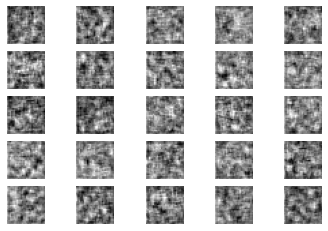

1 [D loss: 0.867003, acc.: 50.00%] [G loss: 0.681020]
2 [D loss: 0.840631, acc.: 57.81%] [G loss: 0.778152]
3 [D loss: 0.770329, acc.: 59.38%] [G loss: 0.826825]
4 [D loss: 0.666485, acc.: 56.25%] [G loss: 0.937212]
5 [D loss: 0.487423, acc.: 75.00%] [G loss: 0.899577]
6 [D loss: 0.510184, acc.: 75.00%] [G loss: 0.852541]
7 [D loss: 0.380910, acc.: 84.38%] [G loss: 0.675155]
8 [D loss: 0.635535, acc.: 71.88%] [G loss: 0.661483]
9 [D loss: 0.634157, acc.: 78.12%] [G loss: 0.961700]
10 [D loss: 0.697200, acc.: 64.06%] [G loss: 1.702175]
11 [D loss: 0.549067, acc.: 75.00%] [G loss: 1.732735]
12 [D loss: 0.685683, acc.: 68.75%] [G loss: 0.932028]
13 [D loss: 0.631906, acc.: 68.75%] [G loss: 0.822853]
14 [D loss: 0.484552, acc.: 75.00%] [G loss: 0.715510]
15 [D loss: 0.517641, acc.: 68.75%] [G loss: 0.960133]
16 [D loss: 0.974108, acc.: 53.12%] [G loss: 0.707571]
17 [D loss: 0.776187, acc.: 57.81%] [G loss: 1.894072]
18 [D loss: 1.031138, acc.: 53.12%] [G loss: 1.421717]
19 [D loss: 0.99951

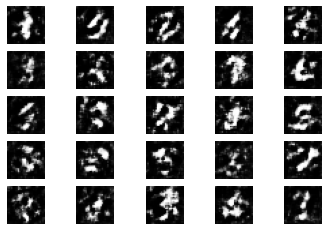

101 [D loss: 0.768811, acc.: 54.69%] [G loss: 1.004256]
102 [D loss: 0.930824, acc.: 50.00%] [G loss: 1.418982]
103 [D loss: 1.083079, acc.: 31.25%] [G loss: 1.389247]
104 [D loss: 1.066144, acc.: 35.94%] [G loss: 1.327156]
105 [D loss: 0.985213, acc.: 39.06%] [G loss: 1.491138]
106 [D loss: 0.779114, acc.: 54.69%] [G loss: 1.094309]
107 [D loss: 0.919876, acc.: 56.25%] [G loss: 0.981587]
108 [D loss: 0.493391, acc.: 78.12%] [G loss: 1.038755]
109 [D loss: 0.481491, acc.: 67.19%] [G loss: 0.941041]
110 [D loss: 0.375195, acc.: 87.50%] [G loss: 0.745498]
111 [D loss: 0.642826, acc.: 57.81%] [G loss: 1.161274]
112 [D loss: 0.499630, acc.: 76.56%] [G loss: 1.071811]
113 [D loss: 0.808582, acc.: 57.81%] [G loss: 1.322336]
114 [D loss: 0.973672, acc.: 43.75%] [G loss: 1.415505]
115 [D loss: 0.769059, acc.: 56.25%] [G loss: 1.310577]
116 [D loss: 1.002335, acc.: 26.56%] [G loss: 1.045360]
117 [D loss: 0.882996, acc.: 43.75%] [G loss: 0.970352]
118 [D loss: 1.078422, acc.: 40.62%] [G loss: 0.

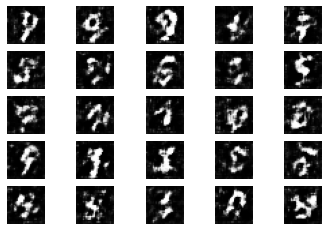

201 [D loss: 0.510499, acc.: 70.31%] [G loss: 1.361825]
202 [D loss: 1.065303, acc.: 32.81%] [G loss: 0.938574]
203 [D loss: 0.407272, acc.: 82.81%] [G loss: 1.087596]
204 [D loss: 0.206738, acc.: 98.44%] [G loss: 1.004617]
205 [D loss: 0.356834, acc.: 85.94%] [G loss: 0.964146]
206 [D loss: 0.721343, acc.: 57.81%] [G loss: 1.123445]
207 [D loss: 0.567368, acc.: 73.44%] [G loss: 1.321349]
208 [D loss: 0.454073, acc.: 82.81%] [G loss: 1.148943]
209 [D loss: 0.614969, acc.: 67.19%] [G loss: 1.028024]
210 [D loss: 0.789987, acc.: 56.25%] [G loss: 1.330083]
211 [D loss: 0.911125, acc.: 50.00%] [G loss: 1.307941]
212 [D loss: 0.437876, acc.: 79.69%] [G loss: 1.214903]
213 [D loss: 0.768469, acc.: 57.81%] [G loss: 0.856803]
214 [D loss: 0.471716, acc.: 76.56%] [G loss: 1.127743]
215 [D loss: 0.657849, acc.: 70.31%] [G loss: 0.955501]
216 [D loss: 0.691241, acc.: 56.25%] [G loss: 1.394469]
217 [D loss: 0.921833, acc.: 48.44%] [G loss: 1.253995]
218 [D loss: 1.059021, acc.: 31.25%] [G loss: 1.

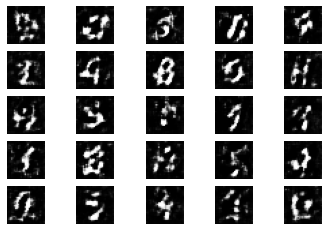

301 [D loss: 0.558265, acc.: 68.75%] [G loss: 0.907786]
302 [D loss: 0.179352, acc.: 96.88%] [G loss: 1.308493]
303 [D loss: 0.530042, acc.: 68.75%] [G loss: 1.141939]
304 [D loss: 0.498668, acc.: 78.12%] [G loss: 0.803226]
305 [D loss: 0.355262, acc.: 89.06%] [G loss: 1.036105]
306 [D loss: 0.766316, acc.: 60.94%] [G loss: 1.529418]
307 [D loss: 1.128694, acc.: 54.69%] [G loss: 0.815536]
308 [D loss: 0.122787, acc.: 98.44%] [G loss: 0.854333]
309 [D loss: 0.052325, acc.: 100.00%] [G loss: 1.115690]
310 [D loss: 0.082740, acc.: 98.44%] [G loss: 0.929188]
311 [D loss: 0.091802, acc.: 100.00%] [G loss: 1.122172]
312 [D loss: 0.040548, acc.: 100.00%] [G loss: 0.895717]
313 [D loss: 0.111901, acc.: 100.00%] [G loss: 0.958773]
314 [D loss: 0.402164, acc.: 78.12%] [G loss: 0.821404]
315 [D loss: 0.077148, acc.: 100.00%] [G loss: 0.921401]
316 [D loss: 0.516210, acc.: 68.75%] [G loss: 0.942153]
317 [D loss: 0.601235, acc.: 76.56%] [G loss: 0.881283]
318 [D loss: 0.324259, acc.: 90.62%] [G los

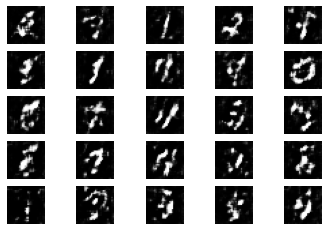

401 [D loss: 0.168347, acc.: 95.31%] [G loss: 0.829479]
402 [D loss: 0.039918, acc.: 100.00%] [G loss: 1.270828]
403 [D loss: 0.559507, acc.: 64.06%] [G loss: 1.088105]
404 [D loss: 0.071844, acc.: 98.44%] [G loss: 1.043905]
405 [D loss: 0.136972, acc.: 95.31%] [G loss: 0.912669]
406 [D loss: 1.446181, acc.: 18.75%] [G loss: 0.837434]
407 [D loss: 0.103733, acc.: 98.44%] [G loss: 1.195828]
408 [D loss: 0.081842, acc.: 98.44%] [G loss: 1.478867]
409 [D loss: 0.045148, acc.: 100.00%] [G loss: 1.922209]
410 [D loss: 0.197136, acc.: 92.19%] [G loss: 2.091620]
411 [D loss: 0.041710, acc.: 100.00%] [G loss: 2.551105]
412 [D loss: 0.015783, acc.: 100.00%] [G loss: 2.546095]
413 [D loss: 0.010077, acc.: 100.00%] [G loss: 2.454498]
414 [D loss: 0.002282, acc.: 100.00%] [G loss: 1.585485]
415 [D loss: 0.062506, acc.: 100.00%] [G loss: 1.311932]
416 [D loss: 0.379616, acc.: 81.25%] [G loss: 1.121518]
417 [D loss: 0.089337, acc.: 100.00%] [G loss: 1.290226]
418 [D loss: 0.159145, acc.: 96.88%] [G 

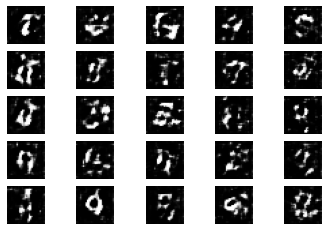

501 [D loss: 0.041963, acc.: 100.00%] [G loss: 0.381174]
502 [D loss: 0.232801, acc.: 87.50%] [G loss: 0.247153]
503 [D loss: 0.007205, acc.: 100.00%] [G loss: 0.435849]
504 [D loss: 0.025553, acc.: 100.00%] [G loss: 1.098130]
505 [D loss: 0.086142, acc.: 98.44%] [G loss: 1.269187]
506 [D loss: 0.076632, acc.: 98.44%] [G loss: 0.967990]
507 [D loss: 0.346014, acc.: 82.81%] [G loss: 1.133354]
508 [D loss: 0.008366, acc.: 100.00%] [G loss: 1.395087]
509 [D loss: 0.051570, acc.: 100.00%] [G loss: 1.328274]
510 [D loss: 0.101975, acc.: 100.00%] [G loss: 1.389332]
511 [D loss: 0.444352, acc.: 81.25%] [G loss: 0.986340]
512 [D loss: 0.253786, acc.: 85.94%] [G loss: 0.901074]
513 [D loss: 0.051210, acc.: 100.00%] [G loss: 0.806593]
514 [D loss: 0.072818, acc.: 100.00%] [G loss: 0.979900]
515 [D loss: 0.055516, acc.: 100.00%] [G loss: 1.032826]
516 [D loss: 0.437844, acc.: 75.00%] [G loss: 0.923622]
517 [D loss: 0.142006, acc.: 95.31%] [G loss: 1.347822]
518 [D loss: 1.082609, acc.: 39.06%] [G

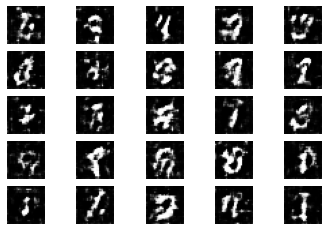

601 [D loss: 0.178350, acc.: 93.75%] [G loss: 1.046471]
602 [D loss: 0.102324, acc.: 98.44%] [G loss: 0.754531]
603 [D loss: 0.141472, acc.: 95.31%] [G loss: 1.039302]
604 [D loss: 0.025041, acc.: 100.00%] [G loss: 0.842297]
605 [D loss: 0.047456, acc.: 100.00%] [G loss: 1.018522]
606 [D loss: 0.011933, acc.: 100.00%] [G loss: 1.027715]
607 [D loss: 0.026986, acc.: 100.00%] [G loss: 0.853684]
608 [D loss: 0.012914, acc.: 100.00%] [G loss: 0.875969]
609 [D loss: 0.205007, acc.: 87.50%] [G loss: 0.882432]
610 [D loss: 0.058484, acc.: 100.00%] [G loss: 1.061779]
611 [D loss: 0.003110, acc.: 100.00%] [G loss: 1.579069]
612 [D loss: 0.017400, acc.: 100.00%] [G loss: 1.813001]
613 [D loss: 0.095297, acc.: 98.44%] [G loss: 2.139637]
614 [D loss: 0.119585, acc.: 96.88%] [G loss: 1.402048]
615 [D loss: 0.032290, acc.: 100.00%] [G loss: 1.306313]
616 [D loss: 0.305074, acc.: 82.81%] [G loss: 0.933271]
617 [D loss: 0.050095, acc.: 98.44%] [G loss: 1.384278]
618 [D loss: 0.069888, acc.: 100.00%] [

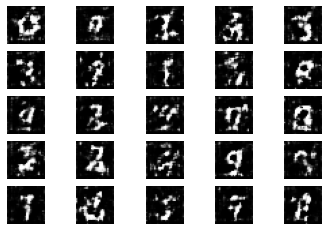

701 [D loss: 0.025559, acc.: 100.00%] [G loss: 0.398924]
702 [D loss: 0.004717, acc.: 100.00%] [G loss: 0.679052]
703 [D loss: 0.001179, acc.: 100.00%] [G loss: 0.872643]
704 [D loss: 0.025402, acc.: 100.00%] [G loss: 0.751842]
705 [D loss: 0.005980, acc.: 100.00%] [G loss: 0.829352]
706 [D loss: 0.002782, acc.: 100.00%] [G loss: 0.694604]
707 [D loss: 0.009868, acc.: 100.00%] [G loss: 0.733961]
708 [D loss: 0.098206, acc.: 98.44%] [G loss: 0.722366]
709 [D loss: 0.001481, acc.: 100.00%] [G loss: 0.797204]
710 [D loss: 0.002711, acc.: 100.00%] [G loss: 0.749936]
711 [D loss: 0.029287, acc.: 100.00%] [G loss: 1.010386]
712 [D loss: 0.000909, acc.: 100.00%] [G loss: 0.665456]
713 [D loss: 0.000903, acc.: 100.00%] [G loss: 0.626511]
714 [D loss: 0.041127, acc.: 100.00%] [G loss: 0.732667]
715 [D loss: 0.062111, acc.: 98.44%] [G loss: 0.351539]
716 [D loss: 0.041735, acc.: 100.00%] [G loss: 0.647234]
717 [D loss: 0.031325, acc.: 100.00%] [G loss: 1.050387]
718 [D loss: 0.002382, acc.: 100.

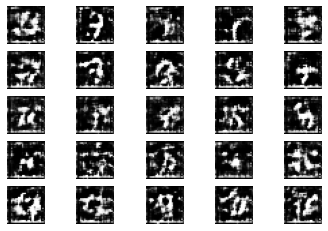

801 [D loss: 0.002373, acc.: 100.00%] [G loss: 0.399133]
802 [D loss: 0.028962, acc.: 100.00%] [G loss: 0.265049]
803 [D loss: 0.019400, acc.: 100.00%] [G loss: 0.352665]
804 [D loss: 0.001696, acc.: 100.00%] [G loss: 0.666895]
805 [D loss: 0.002059, acc.: 100.00%] [G loss: 0.881648]
806 [D loss: 0.000304, acc.: 100.00%] [G loss: 0.807999]
807 [D loss: 0.004613, acc.: 100.00%] [G loss: 0.539723]
808 [D loss: 0.000923, acc.: 100.00%] [G loss: 0.773852]
809 [D loss: 0.000224, acc.: 100.00%] [G loss: 1.051588]
810 [D loss: 0.001856, acc.: 100.00%] [G loss: 0.808515]
811 [D loss: 0.000065, acc.: 100.00%] [G loss: 0.752744]
812 [D loss: 0.001253, acc.: 100.00%] [G loss: 1.226871]
813 [D loss: 0.000440, acc.: 100.00%] [G loss: 1.398669]
814 [D loss: 0.000383, acc.: 100.00%] [G loss: 1.395121]
815 [D loss: 0.000056, acc.: 100.00%] [G loss: 1.258330]
816 [D loss: 0.000075, acc.: 100.00%] [G loss: 1.428696]
817 [D loss: 0.000339, acc.: 100.00%] [G loss: 1.480984]
818 [D loss: 0.000175, acc.: 10

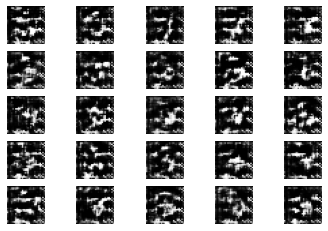

901 [D loss: 0.000280, acc.: 100.00%] [G loss: 0.607292]
902 [D loss: 0.000261, acc.: 100.00%] [G loss: 0.365004]
903 [D loss: 0.000167, acc.: 100.00%] [G loss: 0.456847]
904 [D loss: 0.000087, acc.: 100.00%] [G loss: 0.827979]
905 [D loss: 0.005211, acc.: 100.00%] [G loss: 1.421304]
906 [D loss: 0.000614, acc.: 100.00%] [G loss: 1.091702]
907 [D loss: 0.000350, acc.: 100.00%] [G loss: 1.323525]
908 [D loss: 0.004427, acc.: 100.00%] [G loss: 0.841727]
909 [D loss: 0.000163, acc.: 100.00%] [G loss: 1.257860]
910 [D loss: 0.000395, acc.: 100.00%] [G loss: 1.676226]
911 [D loss: 0.000642, acc.: 100.00%] [G loss: 1.558647]
912 [D loss: 0.000171, acc.: 100.00%] [G loss: 1.325027]
913 [D loss: 0.002909, acc.: 100.00%] [G loss: 1.794891]
914 [D loss: 0.000122, acc.: 100.00%] [G loss: 1.903852]
915 [D loss: 0.000034, acc.: 100.00%] [G loss: 1.861781]
916 [D loss: 0.000058, acc.: 100.00%] [G loss: 1.964960]
917 [D loss: 0.000471, acc.: 100.00%] [G loss: 2.291685]
918 [D loss: 0.000298, acc.: 10

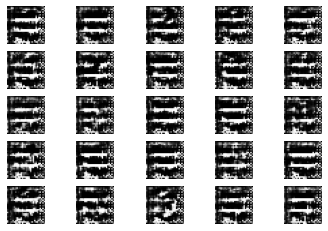

1001 [D loss: 0.000020, acc.: 100.00%] [G loss: 1.930764]
1002 [D loss: 0.000185, acc.: 100.00%] [G loss: 2.296761]
1003 [D loss: 0.000128, acc.: 100.00%] [G loss: 2.382854]
1004 [D loss: 0.000203, acc.: 100.00%] [G loss: 2.597500]
1005 [D loss: 0.000747, acc.: 100.00%] [G loss: 2.491867]
1006 [D loss: 0.000054, acc.: 100.00%] [G loss: 2.506515]
1007 [D loss: 0.000007, acc.: 100.00%] [G loss: 1.940990]
1008 [D loss: 0.000032, acc.: 100.00%] [G loss: 1.852735]
1009 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.609651]
1010 [D loss: 0.000078, acc.: 100.00%] [G loss: 1.635794]
1011 [D loss: 0.000028, acc.: 100.00%] [G loss: 1.983007]
1012 [D loss: 0.000260, acc.: 100.00%] [G loss: 2.078870]
1013 [D loss: 0.000063, acc.: 100.00%] [G loss: 1.794937]
1014 [D loss: 0.000048, acc.: 100.00%] [G loss: 1.873538]
1015 [D loss: 0.000065, acc.: 100.00%] [G loss: 2.115276]
1016 [D loss: 0.000040, acc.: 100.00%] [G loss: 1.674148]
1017 [D loss: 0.000110, acc.: 100.00%] [G loss: 2.151728]
1018 [D loss: 

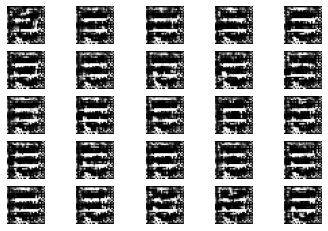

1101 [D loss: 0.000164, acc.: 100.00%] [G loss: 1.832802]
1102 [D loss: 0.000077, acc.: 100.00%] [G loss: 1.476654]
1103 [D loss: 0.000183, acc.: 100.00%] [G loss: 2.095555]
1104 [D loss: 0.000074, acc.: 100.00%] [G loss: 2.260777]
1105 [D loss: 0.000026, acc.: 100.00%] [G loss: 1.475247]
1106 [D loss: 0.000647, acc.: 100.00%] [G loss: 1.449512]
1107 [D loss: 0.000187, acc.: 100.00%] [G loss: 1.760155]
1108 [D loss: 0.000491, acc.: 100.00%] [G loss: 1.928329]
1109 [D loss: 0.000054, acc.: 100.00%] [G loss: 1.465637]
1110 [D loss: 0.000124, acc.: 100.00%] [G loss: 1.418073]
1111 [D loss: 0.000166, acc.: 100.00%] [G loss: 1.367372]
1112 [D loss: 0.000027, acc.: 100.00%] [G loss: 1.085405]
1113 [D loss: 0.000243, acc.: 100.00%] [G loss: 1.132969]
1114 [D loss: 0.000562, acc.: 100.00%] [G loss: 1.582457]
1115 [D loss: 0.000097, acc.: 100.00%] [G loss: 1.172137]
1116 [D loss: 0.000052, acc.: 100.00%] [G loss: 1.392268]
1117 [D loss: 0.000551, acc.: 100.00%] [G loss: 1.613569]
1118 [D loss: 

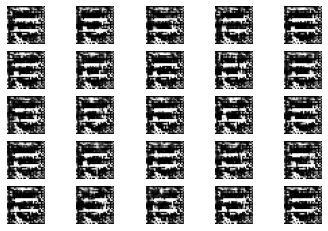

1201 [D loss: 0.000013, acc.: 100.00%] [G loss: 0.503417]
1202 [D loss: 0.000061, acc.: 100.00%] [G loss: 0.656251]
1203 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.499498]
1204 [D loss: 0.000221, acc.: 100.00%] [G loss: 0.584983]
1205 [D loss: 0.000034, acc.: 100.00%] [G loss: 0.724428]
1206 [D loss: 0.000191, acc.: 100.00%] [G loss: 0.866608]
1207 [D loss: 0.000010, acc.: 100.00%] [G loss: 0.600597]
1208 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.500083]
1209 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.537455]
1210 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.504992]
1211 [D loss: 0.000037, acc.: 100.00%] [G loss: 0.649443]
1212 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.566510]
1213 [D loss: 0.000136, acc.: 100.00%] [G loss: 0.685040]
1214 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.566526]
1215 [D loss: 0.000349, acc.: 100.00%] [G loss: 0.879984]
1216 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.560281]
1217 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.667761]
1218 [D loss: 

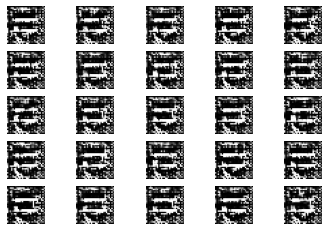

1301 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.481975]
1302 [D loss: 0.001386, acc.: 100.00%] [G loss: 0.953383]
1303 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.554986]
1304 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.370668]
1305 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.558252]
1306 [D loss: 0.003358, acc.: 100.00%] [G loss: 0.845363]
1307 [D loss: 0.000096, acc.: 100.00%] [G loss: 0.781709]
1308 [D loss: 0.000282, acc.: 100.00%] [G loss: 0.686757]
1309 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.448290]
1310 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.290207]
1311 [D loss: 0.000146, acc.: 100.00%] [G loss: 0.664190]
1312 [D loss: 0.000060, acc.: 100.00%] [G loss: 0.397763]
1313 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.415788]
1314 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.271157]
1315 [D loss: 0.000088, acc.: 100.00%] [G loss: 0.293424]
1316 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.384884]
1317 [D loss: 0.000043, acc.: 100.00%] [G loss: 0.359964]
1318 [D loss: 

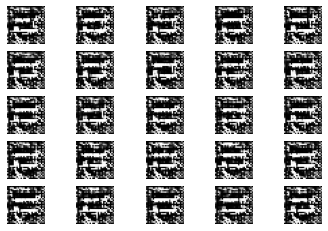

1401 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.194141]
1402 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.272652]
1403 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.232111]
1404 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.146558]
1405 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.216169]
1406 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.184495]
1407 [D loss: 0.000171, acc.: 100.00%] [G loss: 0.176105]
1408 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.207810]
1409 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.202299]
1410 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.229535]
1411 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.308031]
1412 [D loss: 0.000214, acc.: 100.00%] [G loss: 0.381254]
1413 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.369278]
1414 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.274034]
1415 [D loss: 0.000112, acc.: 100.00%] [G loss: 0.295824]
1416 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.231853]
1417 [D loss: 0.000019, acc.: 100.00%] [G loss: 0.262757]
1418 [D loss: 

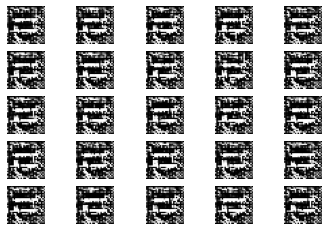

1501 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.253359]
1502 [D loss: 0.000129, acc.: 100.00%] [G loss: 0.476677]
1503 [D loss: 0.000035, acc.: 100.00%] [G loss: 0.284380]
1504 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.303180]
1505 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.163772]
1506 [D loss: 0.000123, acc.: 100.00%] [G loss: 0.239809]
1507 [D loss: 0.000101, acc.: 100.00%] [G loss: 0.484636]
1508 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.368944]
1509 [D loss: 0.000051, acc.: 100.00%] [G loss: 0.254874]
1510 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.333623]
1511 [D loss: 0.000090, acc.: 100.00%] [G loss: 0.357677]
1512 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.324854]
1513 [D loss: 0.000252, acc.: 100.00%] [G loss: 0.398358]
1514 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.387552]
1515 [D loss: 0.000018, acc.: 100.00%] [G loss: 0.336607]
1516 [D loss: 0.000054, acc.: 100.00%] [G loss: 0.240641]
1517 [D loss: 0.000017, acc.: 100.00%] [G loss: 0.211640]
1518 [D loss: 

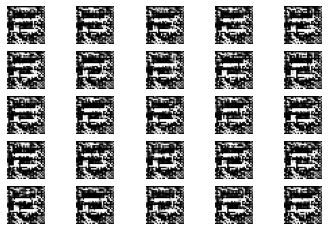

1601 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.286750]
1602 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.266267]
1603 [D loss: 0.000049, acc.: 100.00%] [G loss: 0.343406]
1604 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.305295]
1605 [D loss: 0.000047, acc.: 100.00%] [G loss: 0.381319]
1606 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.317026]
1607 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.218569]
1608 [D loss: 0.000105, acc.: 100.00%] [G loss: 0.281494]
1609 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.274353]
1610 [D loss: 0.000027, acc.: 100.00%] [G loss: 0.194669]
1611 [D loss: 0.000140, acc.: 100.00%] [G loss: 0.355407]
1612 [D loss: 0.000069, acc.: 100.00%] [G loss: 0.337414]
1613 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.254295]
1614 [D loss: 0.000052, acc.: 100.00%] [G loss: 0.277702]
1615 [D loss: 0.000107, acc.: 100.00%] [G loss: 0.426471]
1616 [D loss: 0.000075, acc.: 100.00%] [G loss: 0.329863]
1617 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.178328]
1618 [D loss: 

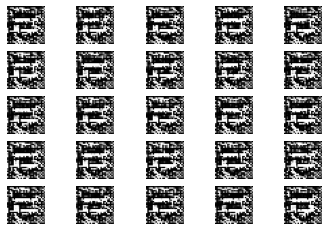

1701 [D loss: 0.000011, acc.: 100.00%] [G loss: 0.414111]
1702 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.160325]
1703 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.141407]
1704 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.270320]
1705 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.204365]
1706 [D loss: 0.000072, acc.: 100.00%] [G loss: 0.254491]
1707 [D loss: 0.000048, acc.: 100.00%] [G loss: 0.272724]
1708 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.267582]
1709 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.347759]
1710 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.348369]
1711 [D loss: 0.000023, acc.: 100.00%] [G loss: 0.286049]
1712 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.316270]
1713 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.327364]
1714 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.224243]
1715 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.342522]
1716 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.361145]
1717 [D loss: 0.000022, acc.: 100.00%] [G loss: 0.214141]
1718 [D loss: 

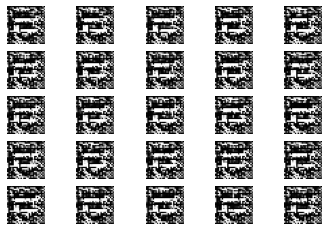

1801 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.180875]
1802 [D loss: 0.000016, acc.: 100.00%] [G loss: 0.130270]
1803 [D loss: 0.000044, acc.: 100.00%] [G loss: 0.247557]
1804 [D loss: 0.000076, acc.: 100.00%] [G loss: 0.240179]
1805 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.149438]
1806 [D loss: 0.000033, acc.: 100.00%] [G loss: 0.206377]
1807 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.187650]
1808 [D loss: 0.000100, acc.: 100.00%] [G loss: 0.306588]
1809 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.330256]
1810 [D loss: 0.000031, acc.: 100.00%] [G loss: 0.320668]
1811 [D loss: 0.000020, acc.: 100.00%] [G loss: 0.232828]
1812 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.236202]
1813 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.156769]
1814 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.250875]
1815 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.301922]
1816 [D loss: 0.000055, acc.: 100.00%] [G loss: 0.333499]
1817 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.264680]
1818 [D loss: 

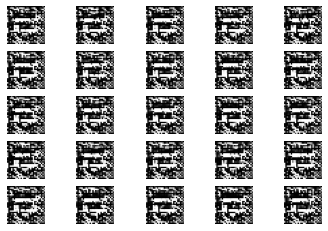

1901 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.278718]
1902 [D loss: 0.000024, acc.: 100.00%] [G loss: 0.189066]
1903 [D loss: 0.000030, acc.: 100.00%] [G loss: 0.178638]
1904 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.130411]
1905 [D loss: 0.000063, acc.: 100.00%] [G loss: 0.187232]
1906 [D loss: 0.000026, acc.: 100.00%] [G loss: 0.190997]
1907 [D loss: 0.000071, acc.: 100.00%] [G loss: 0.321388]
1908 [D loss: 0.000042, acc.: 100.00%] [G loss: 0.250194]
1909 [D loss: 0.000062, acc.: 100.00%] [G loss: 0.241631]
1910 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.278986]
1911 [D loss: 0.000039, acc.: 100.00%] [G loss: 0.246534]
1912 [D loss: 0.000345, acc.: 100.00%] [G loss: 0.276734]
1913 [D loss: 0.000021, acc.: 100.00%] [G loss: 0.236156]
1914 [D loss: 0.000410, acc.: 100.00%] [G loss: 0.263575]
1915 [D loss: 0.000045, acc.: 100.00%] [G loss: 0.308865]
1916 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.344082]
1917 [D loss: 0.000086, acc.: 100.00%] [G loss: 0.229671]
1918 [D loss: 

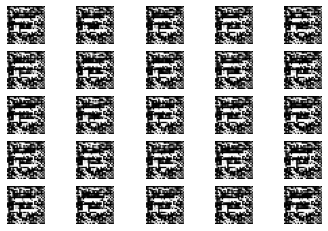

2001 [D loss: 0.000040, acc.: 100.00%] [G loss: 0.254449]
2002 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.127242]
2003 [D loss: 0.000091, acc.: 100.00%] [G loss: 0.266409]
2004 [D loss: 0.000038, acc.: 100.00%] [G loss: 0.257881]
2005 [D loss: 0.000041, acc.: 100.00%] [G loss: 0.223887]
2006 [D loss: 0.000036, acc.: 100.00%] [G loss: 0.163816]
2007 [D loss: 0.000028, acc.: 100.00%] [G loss: 0.252314]
2008 [D loss: 0.000059, acc.: 100.00%] [G loss: 0.264120]
2009 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.191898]
2010 [D loss: 0.000029, acc.: 100.00%] [G loss: 0.235563]
2011 [D loss: 0.000015, acc.: 100.00%] [G loss: 0.198960]
2012 [D loss: 0.000025, acc.: 100.00%] [G loss: 0.155879]
2013 [D loss: 0.000056, acc.: 100.00%] [G loss: 0.130201]
2014 [D loss: 0.000093, acc.: 100.00%] [G loss: 0.201376]
2015 [D loss: 0.000064, acc.: 100.00%] [G loss: 0.212323]
2016 [D loss: 0.000050, acc.: 100.00%] [G loss: 0.193510]
2017 [D loss: 0.000110, acc.: 100.00%] [G loss: 0.299523]
2018 [D loss: 

In [ ]:
dcgan = DCGAN()
dcgan.train(epochs=4000, batch_size=32, save_interval=100)